In [108]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import *
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import *
from  scipy import stats
from sklearn.model_selection import cross_val_score
from category_encoders import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree
import math
import pickle


In [109]:
encoder = TargetEncoder()
weatheDf = pd.read_csv("weather.csv")
weatheDf["encodedlocation"] = encoder.fit_transform(weatheDf['location'], weatheDf['rain'])
weatheDf.time_stamp = pd.to_datetime(weatheDf.time_stamp,unit='s')


In [110]:
#weatheDf.month = weatheDf.time_stamp.dt.month
weatheDf['month'] = weatheDf.time_stamp.dt.month
weatheDf.time_stamp = weatheDf.time_stamp.dt.hour
weatheDf =  weatheDf.rename(
    columns ={
        'time_stamp':'hour'
    }
    )

In [111]:
scaler = MinMaxScaler()
scaler.fit(weatheDf.drop(['rain','location'],axis=1))
#wweatheDf = pd.DataFrame(scaler.transform(weatheDf.drop('rain',axis=1)), columns= weatheDf.drop('rain',axis=1).columns)
weatheDf1 =weatheDf.copy()
weatheDf.dropna(axis=0,inplace=True)
X = weatheDf.drop(['rain','location'],axis=1)
y = weatheDf.rain
x_pred = weatheDf1.drop(['rain','location'],axis=1)

#### Train the model to predict the missing values of rain feature

In [112]:
model = linear_model.LinearRegression()
poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X)
x_pred_poly = poly_features.fit_transform(x_pred)
model.fit(X_train_poly, y)
y_train_predicted = model.predict(x_pred_poly)



In [113]:
y_train_predicted.shape
y_train_predicted
weatheDf1.rain = y_train_predicted


In [114]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.8,frac_test=0.2,
                                         random_state=None):
    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

 

    assert len(df_input) == len(df_train) + len(df_temp)

    return df_train, df_temp

In [115]:
def Feature_Encoder(X, cols):
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
    return X


In [116]:
def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df


In [117]:
weatheDf1.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'hour', 'humidity',
       'wind', 'encodedlocation', 'month'],
      dtype='object')

## working on the Main Dataset

In [118]:
lables = {'unknown': 0, 'moderate': 2, 'cheap': 1,
          'expensive': 3, 'very expensive': 4}
top_feature = list()


In [119]:
def test_sample(sampleData,model):
    sampleData.drop(['product_id'], axis=1, inplace=True)
    sampleData.drop(['id'], axis=1, inplace=True)
    sampleData['RideCategory'] = sampleData['RideCategory'].map(
        lambda x: lables[x])
    y_tru = sampleData['RideCategory']
    sampleData = sampleData[top_feature]
    sampleData.drop(['RideCategory'], axis=1, inplace=True)
    for col in sampleData.select_dtypes(include='O').columns:
        encoder = LabelEncoder()
        encoder.classes_ = np.load(f'{col}.npy', allow_pickle=True)
        sampleData[col] = encoder.transform(sampleData[col])
    scaler = pickle.load(open('scaler.pkl', 'rb'))
    scaler.fit(sampleData)
    sampleData = pd.DataFrame(scaler.transform(sampleData))
    clrf = pickle.load(open(model, 'rb'))
    sample_pred = clrf.predict(sampleData)
    print(f'{model} acc', metrics.accuracy_score(y_tru, sample_pred) * 100.0)
        
    
    

In [120]:
weatherData =weatheDf1.drop('encodedlocation',axis=1)
taxiRidersData = pd.read_csv("taxi-rides-classification.csv")
taxiRidersData.time_stamp = pd.to_datetime(taxiRidersData.time_stamp,unit="ms")
#taxiRidersData.month =taxiRidersData.time_stamp.dt.month
taxiRidersData['month']=(taxiRidersData.time_stamp.dt.month)
taxiRidersData.time_stamp = taxiRidersData.time_stamp.dt.hour
taxiRidersData.rename(
    columns ={
        'time_stamp':'hour'
    }
)


,distance,cab_type,hour,destination,source,surge_multiplier,id,product_id,name,RideCategory,month
0,0.62,Uber,6,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,unknown,12
1,2.27,Uber,10,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,cheap,11
2,2.00,Lyft,0,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,moderate,12
3,3.98,Lyft,23,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,lyft_plus,Lyft XL,expensive,11
4,1.49,Lyft,12,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,lyft,Lyft,cheap,11
...,...,...,...,...,...,...,...,...,...,...,...
554451,1.64,Uber,23,Back Bay,Northeastern University,1.0,2aa98e8a-4f06-4ae2-9291-036d74094a1b,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,moderate,11
554452,0.92,Uber,3,North Station,North End,1.0,75cb7a6d-68be-4cc7-b4da-c8e4b997aa8a,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,expensive,11
554453,2.66,Uber,22,Theatre District,Fenway,1.0,569da280-71c6-4459-a343-8573f8613415,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,moderate,11
554454,2.98,Uber,7,Theatre District,Boston University,1.0,71d8a3a6-5b0e-4710-a803-dfd5680a590a,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,moderate,12


In [121]:
taxiRidersData.dropna(axis=0, inplace=True)
avgWeather = weatherData.groupby(["location"]).mean().reset_index(drop=False)
print(taxiRidersData.columns)
avgWeather.drop(['hour'],axis=1,inplace=True)
avgWeather.drop(['month'],axis=1,inplace=True)
sourceWeather = avgWeather.rename(
    columns={
        'location': 'source',
        'rain': 'source_rain',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)

destinationWeather = avgWeather.rename(
    columns={
        'location': 'destination',
        'rain': 'destination_rain',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'

    }
)


Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source',
       'surge_multiplier', 'id', 'product_id', 'name', 'RideCategory',
       'month'],
      dtype='object')


In [122]:
data = taxiRidersData.merge(sourceWeather, on='source')\
    .merge(destinationWeather, on="destination")
print(data.columns)

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source',
       'surge_multiplier', 'id', 'product_id', 'name', 'RideCategory', 'month',
       'source_temp', 'source_clouds', 'source_pressure', 'source_rain',
       'source_humidity', 'source_wind', 'destination_temp',
       'destination_clouds', 'destination_pressure', 'destination_rain',
       'destination_humidity', 'destination_wind'],
      dtype='object')


### DATA PRE-PROCESSING


In [123]:
# for i  in ((data.product_id + " " + data.name).unique()):
#    print(i)
data.drop(['product_id'],axis=1,inplace=True)
data.drop(['id'],axis=1,inplace=True)
print(data.columns)

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source',
       'surge_multiplier', 'name', 'RideCategory', 'month', 'source_temp',
       'source_clouds', 'source_pressure', 'source_rain', 'source_humidity',
       'source_wind', 'destination_temp', 'destination_clouds',
       'destination_pressure', 'destination_rain', 'destination_humidity',
       'destination_wind'],
      dtype='object')


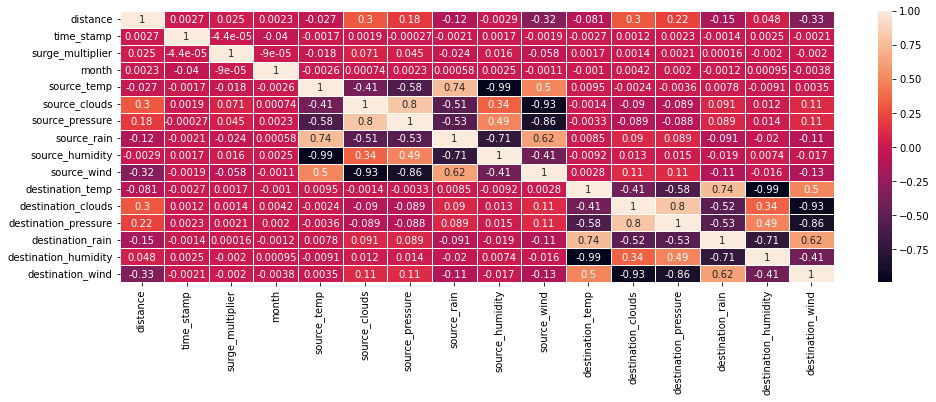

In [124]:
corr = data.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(data.corr(), annot=True, linewidths=1)

In [125]:
dataX = data.drop(['RideCategory'],axis=1)
cor_matrix = dataX.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.92)]
print(to_drop)
data = data.drop(to_drop, axis=1)

['source_humidity', 'source_wind', 'destination_humidity', 'destination_wind']


### remove outliers

In [126]:
def cap_data(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.25,0.75]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

### Encdoing Data

In [127]:
data['RideCategory']=data['RideCategory'].map(lambda x: lables[x])
dataTrain,dataTest = split_stratified_into_train_val_test(data,stratify_colname='RideCategory', frac_train=0.60, frac_test=0.20)

In [128]:
dataTrain = cap_data(dataTrain)
dataTest = cap_data(dataTest)

Using mean Encdoing to encode data since it has great balance between efficency and model complexity

In [129]:
def mean_encoding(data):
    for col in data.select_dtypes(include='O').columns:
        encoder = TargetEncoder()
        data[col] = encoder.fit_transform(data[col],data['RideCategory'])
    return data


In [130]:
def label_encoding(data):
    for col in data.select_dtypes(include='O').columns:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])
        np.save(f'{col}.npy', encoder.classes_)
    return data

In [131]:
dataTrain = label_encoding(dataTrain)
dataTest = label_encoding(dataTest)

Index(['distance', 'cab_type', 'name', 'RideCategory'], dtype='object')


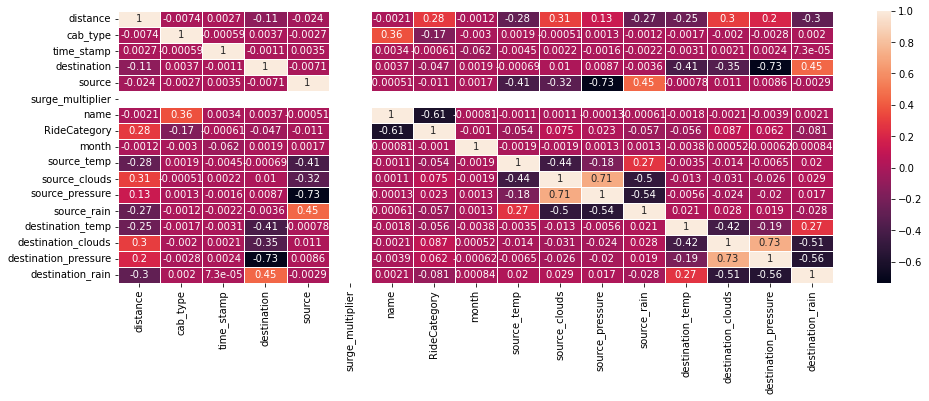

In [132]:
corr = dataTest.corr()
plt.figure(figsize=(16, 5))
dataplot = sns.heatmap(corr, annot=True, linewidths=1)
top_feature = corr.index[abs(corr['RideCategory']) > 0.1]
top_feature.drop('RideCategory')
print(top_feature)
dataTest = dataTest[top_feature]
dataTrain = dataTrain[top_feature]


In [133]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=10)
X_train = dataTrain.drop(['RideCategory'],axis=1)
X_test = dataTest.drop(['RideCategory'],axis=1)
y_train = dataTrain.RideCategory
y_test = dataTest.RideCategory

In [134]:
scaler = MinMaxScaler()
scaler.fit(X_train)
pickle.dump(scaler, open('scaler.pkl', 'wb'))
X_train = pd.DataFrame(scaler.transform(X_train), columns=dataTrain.drop(['RideCategory'], axis=1).columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns= dataTest.drop(['RideCategory'],axis=1).columns)


In [135]:
def decision_tree_model(X_test, X_train, y_test, y_train):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    pickle.dump(clf, open('decision_tree.pkl', 'wb'))
    pred = clf.predict(X_test)
    print('model Test R2', metrics.accuracy_score(y_test, pred) * 100.0)
    

In [136]:
def random_forest_model(X_test, X_train, y_test, y_train, maxDepth):
    clrf = RandomForestClassifier(max_depth=maxDepth, random_state=1)
    clrf.fit(X_train, y_train)
    pickle.dump(clrf, open('random_forest.pkl', 'wb'))
    pred2 = clrf.predict(X_test)
    print('model Test R2', metrics.accuracy_score(y_test, pred2) * 100.0)

In [137]:
#import svc
from sklearn.svm import SVC
def svm_model(X_test, X_train, y_test, y_train):
    #feature reduction
    clf = SVC(kernel='linear', C=1)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('svm_model.pkl', 'wb'))
    pred3 = clf.predict(X_test)
    print('model Test R2', metrics.accuracy_score(y_test, pred3) * 100.0)

In [138]:
#logistic regression
from sklearn.linear_model import LogisticRegression
def logistic_regression_model(X_test, X_train, y_test, y_train):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('logistic_regression.pkl', 'wb'))
    pred4 = clf.predict(X_test)
    print('model Test R2', metrics.accuracy_score(y_test, pred4) * 100.0)

In [139]:
#naiive bayes
from sklearn.naive_bayes import GaussianNB
def naive_bayes_model(X_test, X_train, y_test, y_train):
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('naive_bayes.pkl', 'wb'))
    pred5 = clf.predict(X_test)
    print('model Test R2', metrics.accuracy_score(y_test, pred5) * 100.0)

In [140]:
#ada boost
from sklearn.ensemble import AdaBoostClassifier
def ada_boost_model(X_test, X_train, y_test, y_train):
    clf = AdaBoostClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('ada_boost.pkl', 'wb'))
    pred6 = clf.predict(X_test)
    print(f'ada boost acc', metrics.accuracy_score(y_test, pred6) * 100.0)

In [141]:
logistic_regression_model(X_test, X_train, y_test, y_train)
naive_bayes_model(X_test, X_train, y_test, y_train)
decision_tree_model(X_test, X_train, y_test, y_train)
random_forest_model(X_test, X_train, y_test, y_train, maxDepth=5)
ada_boost_model(X_test, X_train, y_test, y_train)



model Test R2 59.93516184739137
model Test R2 61.08583615516068
model Test R2 89.17500439618907
model Test R2 85.26893404814616
ada boost acc 60.52582930161464


In [142]:
#ignore warrnings
import warnings
warnings.filterwarnings('ignore')
test_sample(pd.read_csv('taxi-test-samples.csv'), 'ada_boost.pkl')
test_sample(pd.read_csv('taxi-test-samples.csv'), 'decision_tree.pkl')
test_sample(pd.read_csv('taxi-test-samples.csv'), 'logistic_regression.pkl')
test_sample(pd.read_csv('taxi-test-samples.csv'), 'naive_bayes.pkl')
test_sample(pd.read_csv('taxi-test-samples.csv'), 'random_forest.pkl')


ada_boost.pkl acc 50.0
decision_tree.pkl acc 75.0
logistic_regression.pkl acc 75.0
naive_bayes.pkl acc 50.0
random_forest.pkl acc 75.0
